In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [181]:
def imshow(img, title=""):
    plt.figure(figsize=(10,10), dpi=192)
    plt.imshow(img, cmap="gray", interpolation="lanczos")
    _ = plt.yticks([])
    _ = plt.xticks([])
    plt.title(title, fontsize=10)

In [139]:
def quantize_colors(img, colors):
    """Quantizes colors to the nearest one"""

    # Conver colors into numpy array to do magic
    colors = np.array(colors)

    # Reshape image
    img_f = np.reshape(img, (-1, 3))

    # Compute distances from each pixel to the color. Note that I use
    # broadcasting.
    dists = img_f.reshape((-1, 1, 3)) - colors.reshape(1, -1, 3)
    # square and add slong the last dimension (i.e. the rgb)
    dists = np.sum(dists**2, axis=-1)

    # Find the one with the smallest distance
    bests = np.argmin(dists, axis=1)

    # Now use these colors instead. Behold the numpy magic. We are now treating
    # the bests as an array holding indices, which what it is, and then using
    # that to recreate a matrix by indexing colors with this index
    # operation. Note that each indexing retrieves 3 elements as color is of
    # shape Nx3. Thus if bests was Mx1, we get Mx3 matrix at the end. This is
    # quite advanced so if you are interested you can come talk to me.
    img_new = colors[bests]

    # Reshape into the original images shape
    img_new = np.reshape(img_new, img.shape)

    return img_new



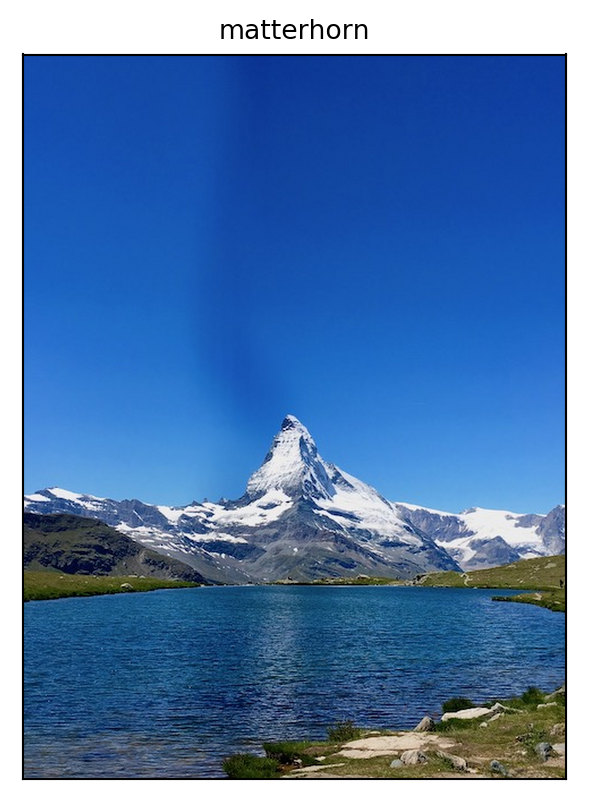

In [140]:
img = cv2.imread("../images/matterhorn.jpg")[..., ::-1]
imshow(img, "matterhorn")

There are 32 unique colors in this image


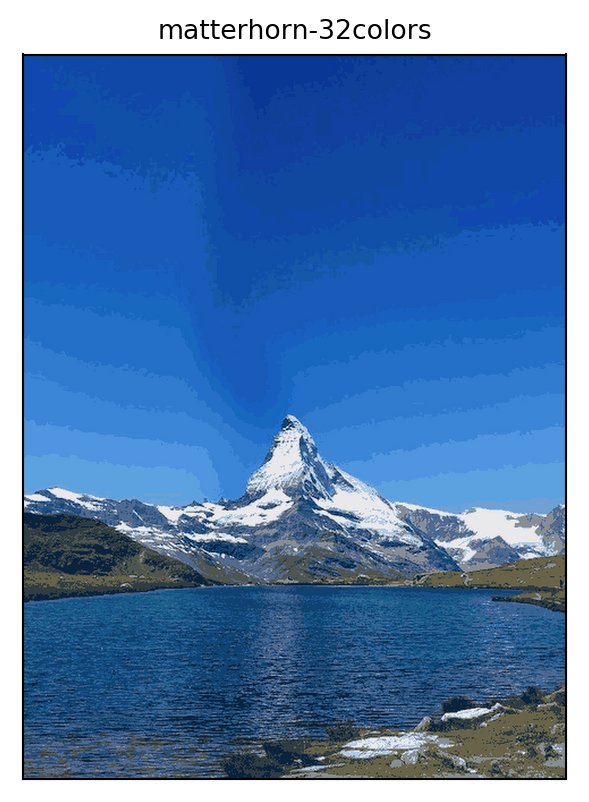

In [141]:
img_c32 = cv2.imread("../images/matterhorn32.png")[..., ::-1]
imshow(img_c32, "matterhorn-32colors")
colors = np.unique(img_c32.reshape(-1, 3), axis=0)
print("There are {} unique colors in this image".format(colors.shape[0]))

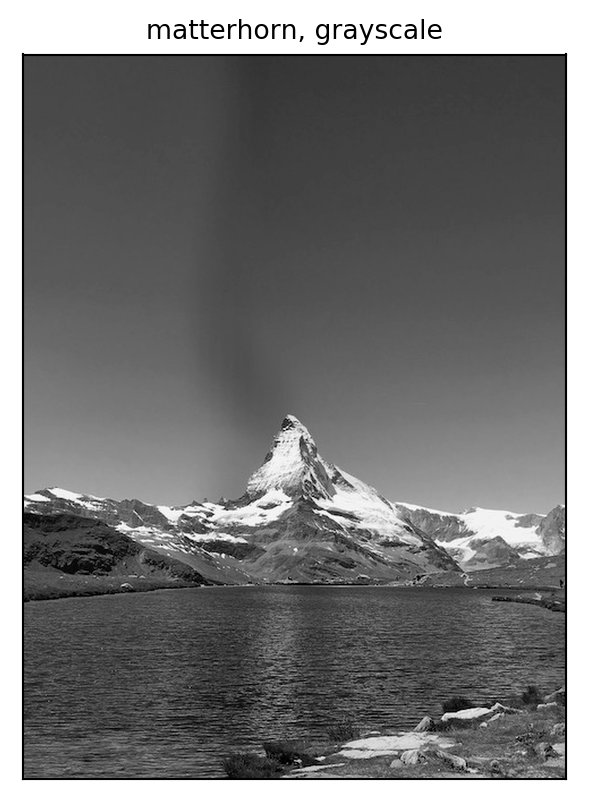

In [142]:
img_gray = cv2.imread("../images/matterhorn.jpg", 0)
imshow(img_gray, "matterhorn, grayscale")

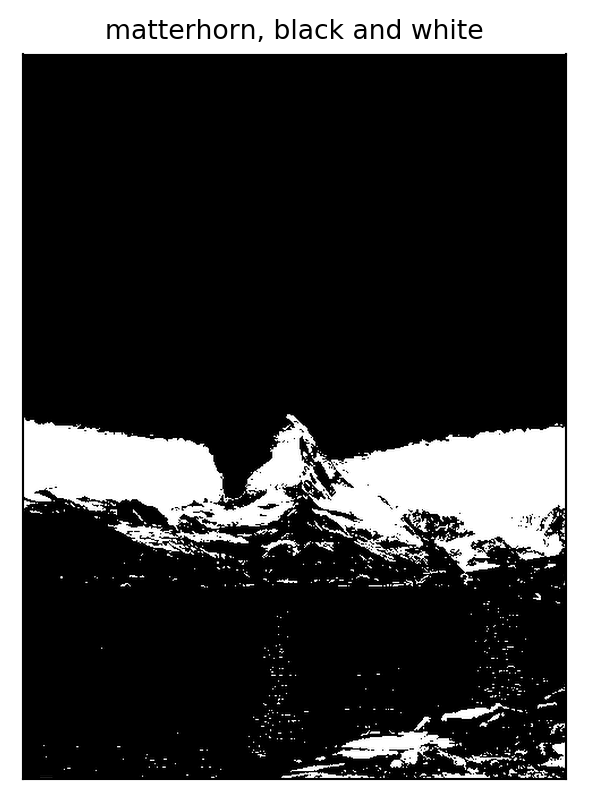

In [143]:
img_bw = (img_gray >= 128) * 255
imshow(img_bw, "matterhorn, black and white")

# Random Modulation

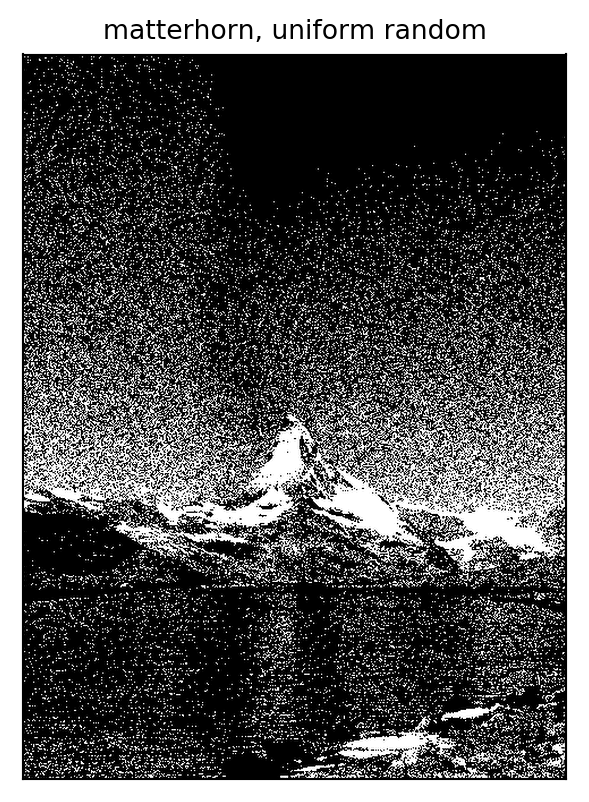

In [144]:
rand_strength = 256 * 0.5
img_rand = img_gray + rand_strength * np.random.rand(*img_gray.shape) - 0.5 * rand_strength
img_bw = (img_rand >= 128) * 255
imshow(img_bw, "matterhorn, uniform random")

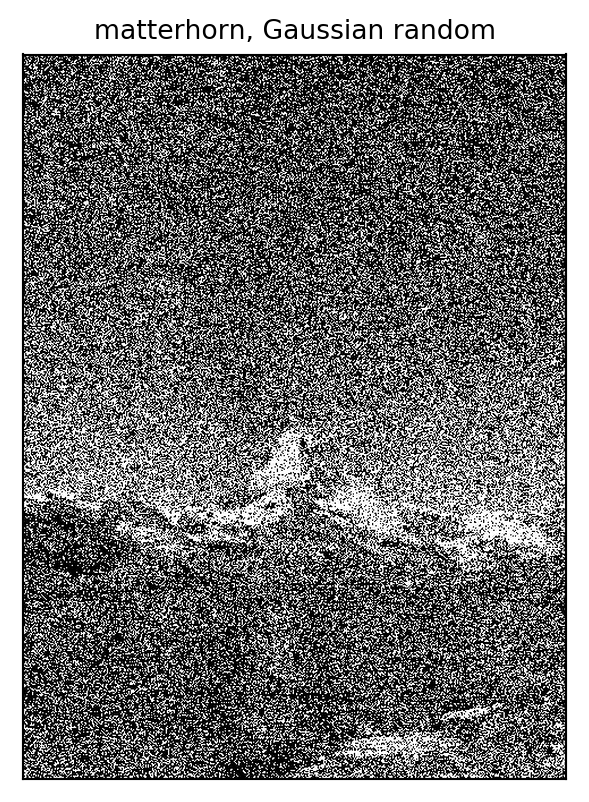

In [145]:
rand_strength = 256 * 0.4
img_rand = img_gray + rand_strength * np.random.normal(size=img_gray.shape)
img_bw = (img_rand >= 128) * 255
imshow(img_bw, "matterhorn, Gaussian random")

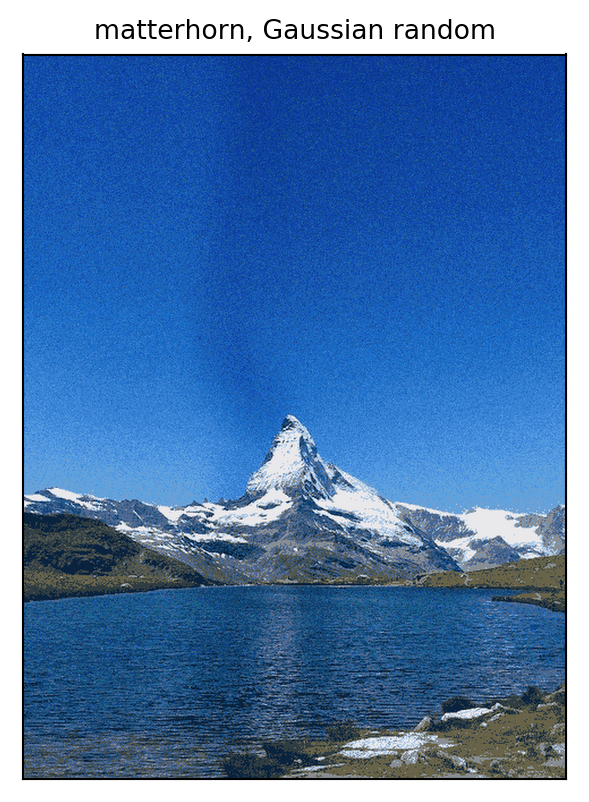

In [146]:
rand_strength = 12
img_rand = img + rand_strength * np.random.normal(size=img_c32.shape)
img_c32_rand = quantize_colors(img_rand, colors)
imshow(img_c32_rand, "matterhorn, Gaussian random")

# Ordered Dithering

In [147]:
# Ordered Dithering using Bayer's mask
def create_bayer(rounds):
    if rounds > 0:
        mask_prev = create_bayer(rounds - 1)
        mask = np.concatenate([
            np.concatenate([4 * mask_prev + 1, 4 * mask_prev + 2], axis=1),
            np.concatenate([4 * mask_prev + 3, 4 * mask_prev + 0], axis=1)
        ], axis=0)
        n = int(np.sqrt(mask.size))
        mask = np.reshape(mask, (n, n))
        return mask
    else:
        return np.array([[0]])

[[ 5  9  6 10]
 [13  1 14  2]
 [ 7 11  4  8]
 [15  3 12  0]]


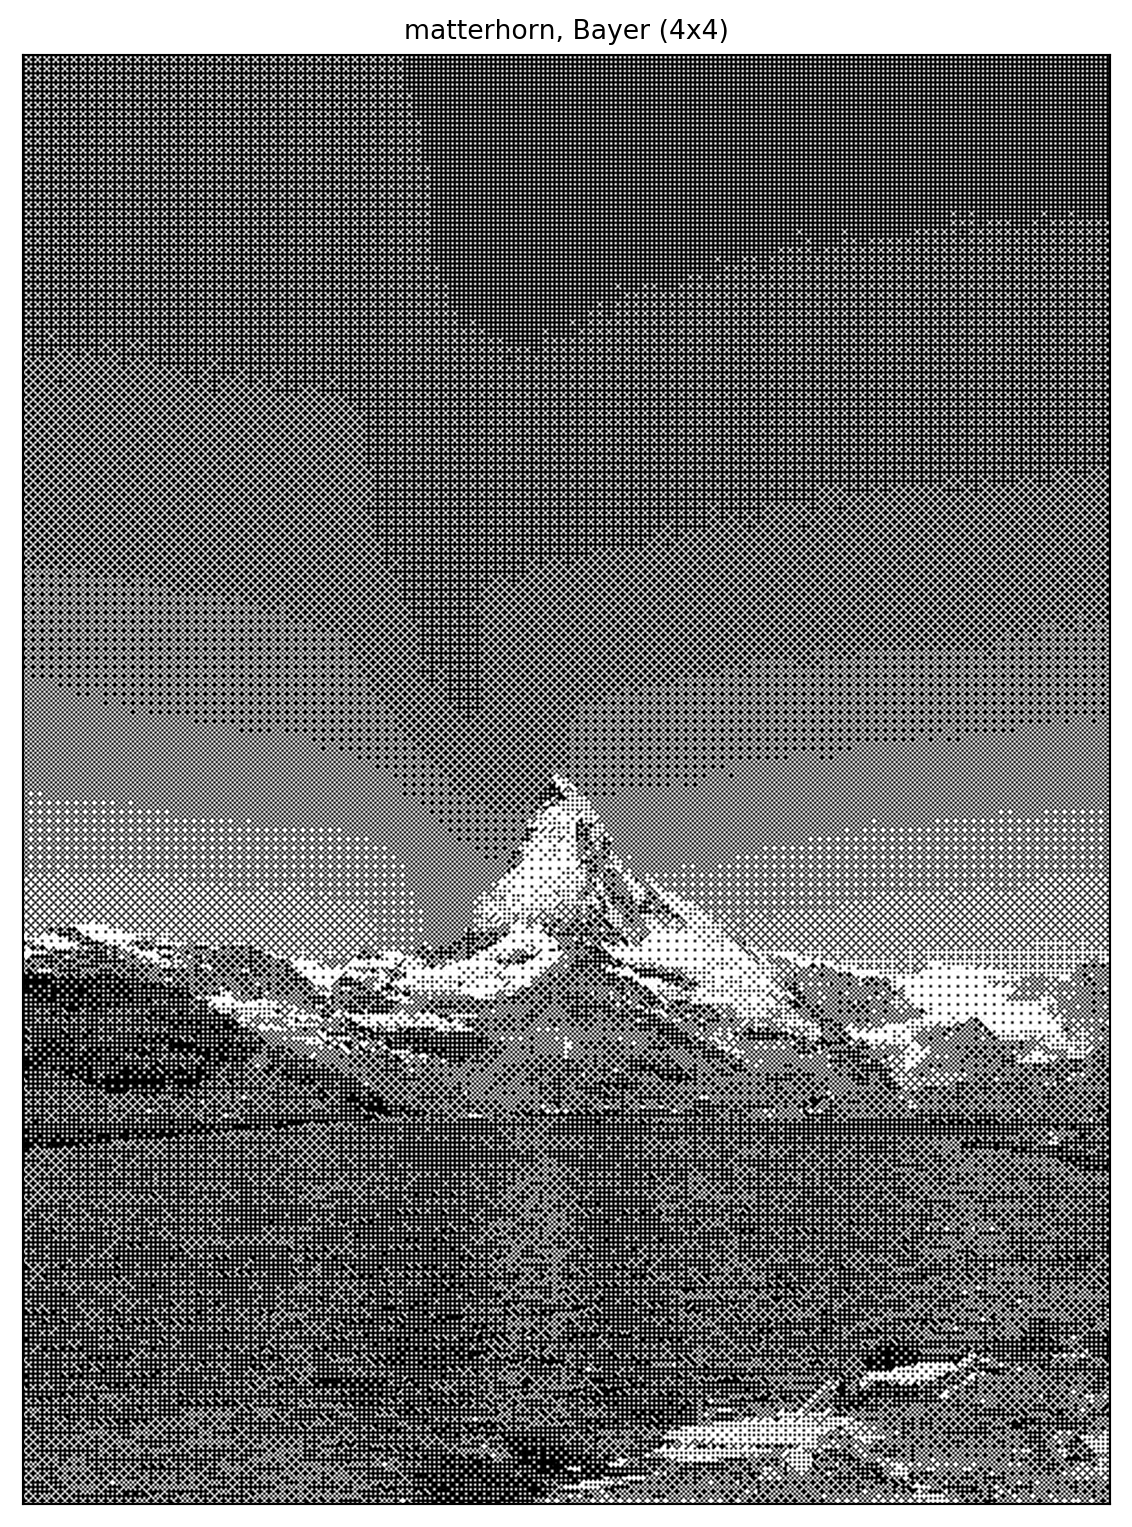

In [183]:
# Create the threshold mask
n = 2
mask = create_bayer(n)
print(mask)
th_mask = mask * 256 / 2**(2*n)
# Tile the mask (we can do for loop as well)
th_mask = np.tile(th_mask, [
    int(np.ceil(img_gray.shape[0] / th_mask.shape[0])), 
    int(np.ceil(img_gray.shape[1] / th_mask.shape[1]))
])
# In case the tiled threshold is larger, we crop
th_mask[:img_gray.shape[0],:img_gray.shape[1]]

img_bw = (img_gray > th_mask) * 255
imshow(img_bw, "matterhorn, Bayer ({}x{})".format(2**n, 2**n))

## Clustered dot

[[62 57 48 36 37 49 58 63]
 [56 47 35 21 22 38 50 59]
 [46 34 20 10 11 23 39 51]
 [33 19  9  3  0  4 12 24]
 [32 18  8  2  1  5 13 25]
 [45 31 17  7  6 14 26 40]
 [55 44 30 16 15 27 41 52]
 [61 54 43 29 28 42 53 60]]


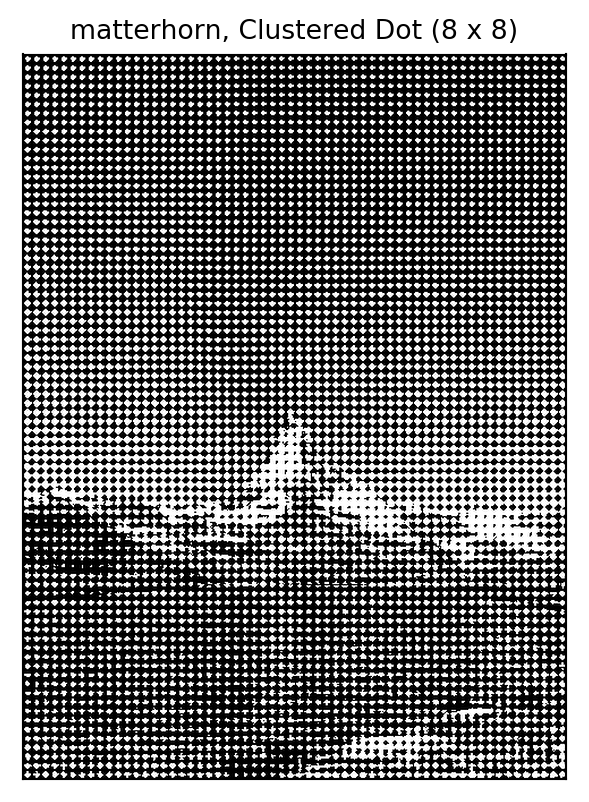

In [179]:
mask = np.array([62,57,48,36,37,49,58,63,56,47,35,21,22,38,50,59,46,34,20,10,11,23,39,51,33,19,9,3,0,4,12,24,32,18,8,2,1,5,13,25,45,31,17,7,6,14,26,40,55,44,30,16,15,27,41,52,61,54,43,29,28,42,53,60])
mask = mask.reshape(8,8)
print(mask)
th_mask = mask * 256 / (8*8)
# Tile the mask (we can do for loop as well)
th_mask = np.tile(th_mask, [
    int(np.ceil(img_gray.shape[0] / th_mask.shape[0])), 
    int(np.ceil(img_gray.shape[1] / th_mask.shape[1]))
])
# In case the tiled threshold is larger, we crop
th_mask[:img_gray.shape[0],:img_gray.shape[1]]

img_bw = (img_gray > th_mask) * 255
imshow(img_bw, "matterhorn, Clustered Dot (8 x 8)")

# Error Diffusion

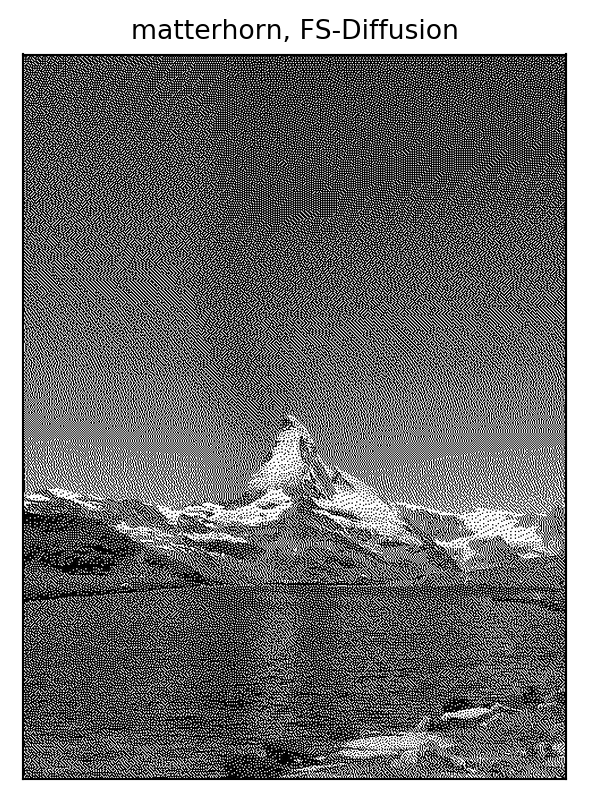

In [153]:
# Init output buffer
img_bw = img_gray.copy().astype(int)
for j in range(img_bw.shape[0]):
    for i in range(img_bw.shape[1]):
        old = img_bw[j, i]
        new = (img_bw[j, i] >= 128) * 255
        img_bw[j, i] = new
        err = old - new
        if i < img_bw.shape[1] - 1:
            img_bw[j    ][i + 1] += err * 7 / 16
        if j < img_bw.shape[0] - 1:
            img_bw[j + 1][i - 1] += err * 3 / 16
            img_bw[j + 1][i    ] += err * 5 / 16
            if i < img_bw.shape[1] - 1:
                img_bw[j + 1][i + 1] += err * 1 / 16
imshow(img_bw, "matterhorn, FS-Diffusion")

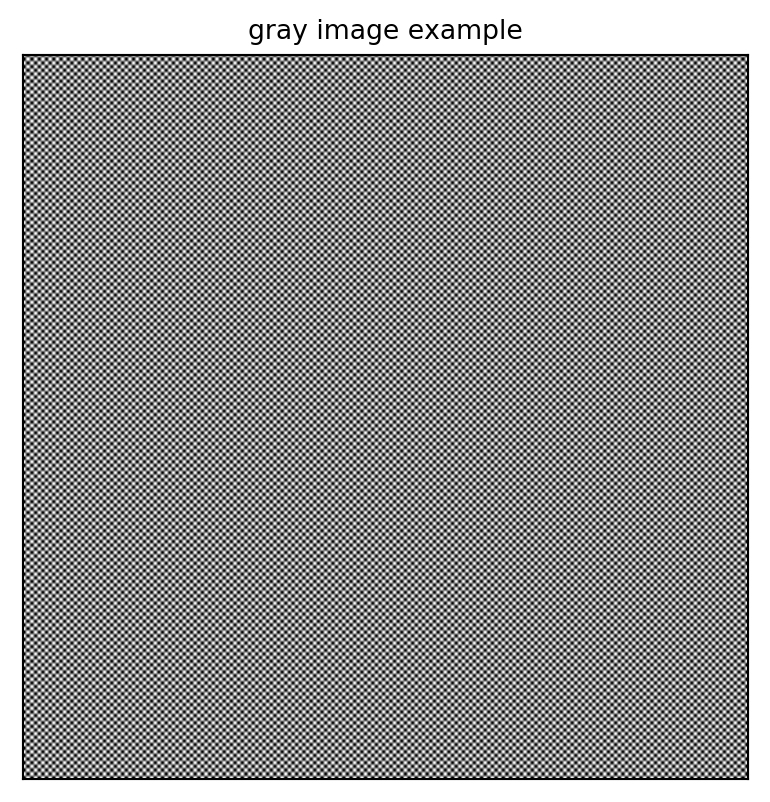

In [170]:
# Example on a gray image
img_bw = np.ones((200,200), dtype=np.int) * 129
for j in range(img_bw.shape[0]):
    for i in range(img_bw.shape[1]):
        old = img_bw[j, i]
        new = (img_bw[j, i] >= 128) * 255
        img_bw[j, i] = new
        err = old - new
        if i < img_bw.shape[1] - 1:
            img_bw[j    ][i + 1] += err * 7 / 16
        if j < img_bw.shape[0] - 1:
            img_bw[j + 1][i - 1] += err * 3 / 16
            img_bw[j + 1][i    ] += err * 5 / 16
            if i < img_bw.shape[1] - 1:
                img_bw[j + 1][i + 1] += err * 1 / 16
imshow(img_bw, "gray image example")